##### Name:           Berkay Koçak
##### Student ID:   614468
##### E-mail:          kocakberkayy@gmail.com

# Introduction

Return shipping has become a significant expense item for online retailers. Customers are returning a substantial amount of their purchases that they bought online which yields extra shipping costs for the shops. In the scope of this project, it is aimed to reduce the shipping related costs by predicting the items that have a high probability of return and discouraging the sale in the first place while paying attention not to deter any successful sales.

In order to come up with a solution to this binary classification problem, there are mainly two tree-based ensemble learners that are tested: Extreme Gradient Boosting and Random Forest Classifier. Random Forest Classifier proved to be a better option  for this specific problem thanks to its robustness and high AUC score. After the hyperparameter tuning of the model, the Bayes decision rule is used to come up with binary predictions that are cost sensitive.

In [14]:
#importing the necessary libraries and install commands for the libraries that are not available at the conda environment.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scorecardpy as sc
import datetime
import warnings
import xgboost as xgb
from xgboost import XGBClassifier
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#pip install scorecardpy
#pip install xgboost
#pip install tabulate
#conda update scikit-learn

In [15]:
# Show the warnings in the notebook only once.
warnings.filterwarnings(action='once')

In [16]:
#reading the train data
df_known = pd.read_csv(r'C:\Users\Berkay Kocak\Desktop\BADS Assignment\BADS_WS2021_known.csv', index_col='order_item_id')

## First inspection of data

The project commences with the first inspection of the data. Although the variables are not analyzed thorougly, the outstanding errors are corrected while getting familiar with the data in this section.

In [17]:
#The name of the column "return" has been changed in order not to create any confusions in algorithms.
df_known = df_known.rename(columns={'return': 'returned'})

In [18]:
print('Dimensionality of the data is {}'.format(df_known.shape))
print('The data set has {} cases.'.format(df_known.shape[0]))
print('The data set has {} variables.'.format(df_known.columns))

Dimensionality of the data is (100000, 13)
The data set has 100000 cases.
The data set has Index(['order_date', 'delivery_date', 'item_id', 'item_size', 'item_color',
       'brand_id', 'item_price', 'user_id', 'user_title', 'user_dob',
       'user_state', 'user_reg_date', 'returned'],
      dtype='object') variables.


In [19]:
df_known.head(n=5)

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,returned
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


In [20]:
df_known.tail(n=5)

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,returned
order_item_id,,,,,,,,,,,,,
99996,2016-09-11,2016-09-12,156,20,blue,34,29.9,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99997,2016-09-11,2016-09-12,156,20,brown,34,29.9,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99998,2016-09-11,1994-12-31,1832,xxl,black,37,26.9,47794,Mr,1985-03-01,Hamburg,2016-09-10,0
99999,2016-09-11,1994-12-31,1832,xxl,black,37,26.9,47794,Mr,1985-03-01,Hamburg,2016-09-10,0
100000,2016-09-11,2016-10-08,1891,28,fuchsia,47,27.9,2622,Mrs,1973-10-17,Lower Saxony,2015-02-17,0


In [21]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
order_date       100000 non-null object
delivery_date    90682 non-null object
item_id          100000 non-null int64
item_size        100000 non-null object
item_color       100000 non-null object
brand_id         100000 non-null int64
item_price       100000 non-null float64
user_id          100000 non-null int64
user_title       100000 non-null object
user_dob         91275 non-null object
user_state       100000 non-null object
user_reg_date    100000 non-null object
returned         100000 non-null int64
dtypes: float64(1), int64(4), object(8)
memory usage: 10.7+ MB


In [22]:
df_known.describe(include='all')

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,returned
count,100000,90682,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000,91275,100000,100000,100000.000000
unique,82,123,NaN,102,77,NaN,NaN,NaN,5,9247,16,573,NaN
top,2016-06-27,2016-07-03,NaN,l,black,NaN,NaN,NaN,Mrs,1900-11-21,North Rhine-Westphalia,2015-02-17,NaN
freq,5577,5061,NaN,12347,18640,NaN,NaN,NaN,95429,919,22825,33966,NaN
mean,NaN,NaN,923.781820,NaN,NaN,30.149020,65.064695,27169.073960,NaN,NaN,NaN,NaN,0.458180
std,NaN,NaN,702.568822,NaN,NaN,28.180191,47.991546,14053.417669,NaN,NaN,NaN,NaN,0.498251
min,NaN,NaN,1.000000,NaN,NaN,1.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,214.000000,NaN,NaN,5.000000,29.900000,14937.000000,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,812.000000,NaN,NaN,25.000000,49.900000,31189.000000,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,1581.000000,NaN,NaN,44.000000,79.900000,38917.250000,NaN,NaN,NaN,NaN,1.000000


In [23]:
print('Mean value for item prices is {}'.format(df_known["item_price"].mean()),'Median value for item prices is {}'.format(df_known["item_price"].median()), sep="\n")
print("\n")
print('The returned value counts are: \n{}'.format(df_known.returned.value_counts()))
print("\n")
print('The mean prices of non-returned and returned items are: \n{}'.format(df_known.groupby("returned")["item_price"].mean()))

Mean value for item prices is 65.0646952000678
Median value for item prices is 49.9


The returned value counts are: 
0    54182
1    45818
Name: returned, dtype: int64


The mean prices of non-returned and returned items are: 
returned
0    58.882494
1    72.375447
Name: item_price, dtype: float64


The continuous variable "item_price" is further analyzed. Here, it is seen that the item price varies between the cases where the item is returned and the item is not returned. Item price seems to be an important variable according to the first inspection.

In [24]:
#It is discovered that there are some typos regarding the colors of the items.These mistakes are handled.
df_known.item_color[df_known["item_color"]=="blau"] = "blue"
df_known.item_color[df_known["item_color"]=="brwon"] = "brown"
df_known.item_color.value_counts()

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


black             18640
blue              10851
brown              8747
grey               8708
red                7264
                  ...  
currant purple        7
amethyst              5
avocado               4
creme                 4
opal                  2
Name: item_color, Length: 75, dtype: int64

In [25]:
#The data types of the variables are changed.
df_known['returned'] = df_known['returned'].astype('bool')
df_known['order_date'] = pd.to_datetime(df_known['order_date'])
df_known['delivery_date'] = pd.to_datetime(df_known['delivery_date'])
df_known['user_dob'] = pd.to_datetime(df_known['user_dob'])
df_known['user_reg_date'] = pd.to_datetime(df_known['user_reg_date'])
df_known['item_size'] = df_known['item_size'].astype('category')
df_known['item_color'] = df_known['item_color'].astype('category')
df_known['user_title'] = df_known['user_title'].astype('category')
df_known['user_state'] = df_known['user_state'].astype('category')

In [26]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
order_date       100000 non-null datetime64[ns]
delivery_date    90682 non-null datetime64[ns]
item_id          100000 non-null int64
item_size        100000 non-null category
item_color       100000 non-null category
brand_id         100000 non-null int64
item_price       100000 non-null float64
user_id          100000 non-null int64
user_title       100000 non-null category
user_dob         91275 non-null datetime64[ns]
user_state       100000 non-null category
user_reg_date    100000 non-null datetime64[ns]
returned         100000 non-null bool
dtypes: bool(1), category(4), datetime64[ns](4), float64(1), int64(3)
memory usage: 7.4 MB


order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
returned            0
dtype: int64


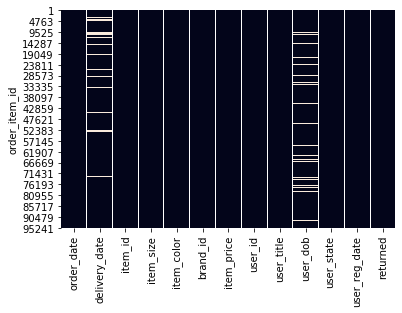

In [27]:
#Analyzing the missing values.
print(df_known.isnull().sum())
sns.heatmap(df_known.isnull(), cbar=False)

The first inspection of the data has shown that the data set is fairly balanced with nearly 45k returned and 55k non returned items. Moreover, it might be seen that there are 4 columns that includes several dates, 4 columns that include categorical variables, 3 columns that include integer values such as brand_id and item_id and one column that is the price of the item. It is seen that there are missing values in 2 columns, namely "user_dob" and "delivery_date. On the next part of this paper, main focus will be on creating new variables from the existing ones that the machine learning algorithms might effectively work. During this process, the missing values of the related columns will also be handled.

# Data Preperation & Feature Engineering

In this part of the project, there will be new variables that are added to the model by feature engineering while the data is analyzed variable by variable.

### Delivery Time

In [28]:
#The delivery time is added in terms of weeks.
df_known["delivery_time_weeks"]=round((df_known["delivery_date"]-df_known["order_date"]).dt.days/7)

The delivery time is basically the time difference between the delivery date and the order date. During the data preperation, other time periods are also tried such as days and months. However, weeks proved to be having the highest correlation with the returning decision. Moreover, calculating the delivery time in terms of weeks is also a logical approach since the return decision usually does not vary too much between days. The delivery time is a significant factor for the user to return the item or not since long waiting times for the deliveries might be really tiring for the customer.

In [29]:
na_delivery_times=df_known[["returned","delivery_time_weeks","order_date","delivery_date"]][df_known.delivery_time_weeks.isnull()]
print('The returned and non-returned counts for missing cases: \n{}'.format(na_delivery_times.returned.value_counts()))
neg_delivery_times=df_known[["returned","delivery_time_weeks","order_date","delivery_date"]][df_known.delivery_time_weeks<0]
print("\n")
print('The returned and non-returned counts for negative cases: \n{}'.format(neg_delivery_times.returned.value_counts()))
print("\n")
print('Percentage of items returned for each delivery time week: \n{}'.format(df_known.groupby("delivery_time_weeks")["returned"].mean()))

The returned and non-returned counts for missing cases: 
False    9318
Name: returned, dtype: int64


The returned and non-returned counts for negative cases: 
False    669
True     403
Name: returned, dtype: int64


Percentage of items returned for each delivery time week: 
delivery_time_weeks
-1132.0    0.135593
-1131.0    0.285714
-1130.0    0.648649
-1129.0    0.172043
-1128.0    0.200000
-1127.0    0.450000
-1126.0    0.131579
-1125.0    0.250000
-1124.0    0.418605
-1123.0    0.361702
-1122.0    0.604396
-1121.0    0.551913
 0.0       0.508534
 1.0       0.525775
 2.0       0.485073
 3.0       0.427356
 4.0       0.443713
 5.0       0.478298
 6.0       0.434731
 7.0       0.480831
 8.0       0.483232
 9.0       0.524178
 10.0      0.531401
 11.0      0.561350
 12.0      0.497908
 13.0      0.506494
 14.0      0.529412
 15.0      0.514286
 16.0      0.652174
 17.0      0.166667
 18.0      1.000000
 19.0      0.500000
 20.0      0.000000
 22.0      0.000000
 25.0      1.000000
Name

If the null values and the negative values are analyzed, one can see that these values have different distribution in terms or returning decision compared to other delivery times. Especially in the null values case, it can be seen that all of the cases are concluding in a non-returning item which is highly specific. 

In [30]:
#Inspection of negative delivery times
neg_delivery_times.sort_values(by="delivery_date",ascending=False)

,returned,delivery_time_weeks,order_date,delivery_date
order_item_id,,,,
287,False,-1121.0,2016-06-23,1994-12-31
61673,False,-1127.0,2016-08-09,1994-12-31
57462,True,-1127.0,2016-08-07,1994-12-31
57463,True,-1127.0,2016-08-07,1994-12-31
57464,True,-1127.0,2016-08-07,1994-12-31
...,...,...,...,...
29889,True,-1122.0,2016-07-05,1994-12-31
29890,True,-1122.0,2016-07-05,1994-12-31
29891,True,-1122.0,2016-07-05,1994-12-31


It is seen that the delivery times that have negative values are associated with the delivery date: "1994-12-31". Therefore it may concluded that these values might also correspond to missing delivery dates. These negative and missing delivery dates could be replaced by adding mean delivery time to the individual order dates. However, in the scope of this project dates are not used as input variables. Therefore, only the delivery times are replaced by the mean value.

In [31]:
df_known_non_na_delivery_times=df_known[df_known.delivery_time_weeks>=0]

In [32]:
print('Mean delivery time for non-missing and non-negative deliveries: \n{}'.format(df_known_non_na_delivery_times.delivery_time_weeks.mean()))

Mean delivery time for non-missing and non-negative deliveries: 
0.9660082580069189


It is found out that the mean delivery time of deliveries that do not have negative or "NaT" values are 0.96 weeks. This can be rounded to 1 week. Therefore, for NaT or "1994-12-31" delivery dates the delivery time may be replaced with 1 week . Another option is discretizing the continuous variable. Since these NaT and and negative values have different distributions and further analysis of the delivery time column revealed that there are too many outliers, it is also logical to discretize the continuous variable into categories. These categories are determined by analyzing the return rates of the customers and some logical assumptions about when would a customer become tired of waiting.

In [33]:
#Discretizing the continuous variable delivery time
df_known["delivery_time_cat"]=df_known.delivery_time_weeks.fillna("IsMissing")
df_known.delivery_time_cat[df_known["delivery_time_weeks"]<0]="IsNegative"
df_known.delivery_time_cat[df_known["delivery_time_weeks"]>=3]="3-4"
df_known.delivery_time_cat[df_known["delivery_time_weeks"]>=5]="5+"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


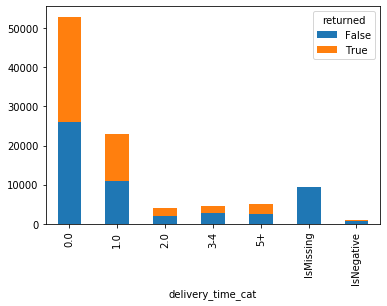

In [34]:
del_time = df_known.groupby(['returned', 'delivery_time_cat']).size().reset_index().pivot(columns='returned', index='delivery_time_cat', values=0)
                                                                       
del_time.plot(kind='bar', stacked=True);

In [35]:
#Changing na and neg values by median
df_known.delivery_time_weeks.fillna(1,inplace=True)
df_known.delivery_time_weeks[df_known["delivery_time_weeks"]<0]= 1

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Both of the delivery time columns are kept for now since high correlation between variables is not an issue for tree based algorithms such as XGB and RFC that will be used in this project. The best features of the models might be analyzed thoroughly in the model decision section.

### Time Since Registration

In [36]:
df_known["months_since_reg"]=round((max(df_known["user_reg_date"])-df_known["user_reg_date"]).dt.days/30)

The time since registration is added in terms of months. During the data preperation phase, other time periods are also tried such as days and weeks. However, months proved to be having the highest correlation with the returning decision. Moreover, calculating the time since registration in terms of months is also a logical approach since the return decision usually does not vary too much between weeks. During the calculation maxiumum user_reg_date has been used as a referance to calculate the days since registration. In other words, the newest user is accepted to be a reference point for all other customers to calculate the time since their registration. The time since registration might also be a significant factor for the users' returning behavior which will be analyzed further in explarotary data analysis part.

### Age

In [37]:
print('Number of missing date of births: {}'.format(df_known["user_dob"].isnull().sum()))
user_dobs=df_known.groupby("user_id")["user_dob"].max()
print('Number of users that do not have a date of birth: {}'.format(user_dobs.isnull().sum()))

Number of missing date of births: 8725
Number of users that do not have a date of birth: 2223


In [38]:
#The age of the user is calculated by taking the difference between the registration date and the date of birth.
df_known["age"]=round((max(df_known["user_reg_date"])-df_known["user_dob"]).dt.days/365)

The age column is added. While calculating the age of the users, the user_reg_date of the newest customer is again used as a reference point. It is again seen that number of missing values forms a significant part of the data. Therefore it needs to be handled. The age should also be an important factor for the returning decision of the customer since different generations have very distinct relationships with the online shopping. The new generations have adapted to using online shopping fairly well compared to the older generations.

In [39]:
na_ages=df_known[["returned","age"]][df_known.age.isnull()]
print('The returned and non-returned counts for missing cases: \n{}'.format(na_ages.returned.value_counts()))

The returned and non-returned counts for missing cases: 
False    4757
True     3968
Name: returned, dtype: int64


In [40]:
df_known["age_cat"]=df_known.age.fillna("Missing")
df_known.age_cat[df_known["age"]<25]="Gen Z"
df_known.age_cat[df_known["age"]>=25]="Gen Y"
df_known.age_cat[df_known["age"]>=41]="Gen X"
df_known.age_cat[df_known["age"]>=57]="Baby-Boomers"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


The same approach as the delivery time is taken for the variable age. A seperate column containing several categories is formed including a "Missing" category. The age categories are formed as GenX, GenY, GenZ and Baby-Boomers. Since, each of these generations have a different kind of relationship with new technology and online shopping, it makes sense to categorize the column this way. Moreover, the division of the data between these categories is also logical since otherwise the data would have a big amount of outliers as further analysis showed.

In [41]:
#The missing values are replaced by the median for the age column
median = df_known["age"].median(skipna=True)
df_known["age"].fillna(median, inplace=True)

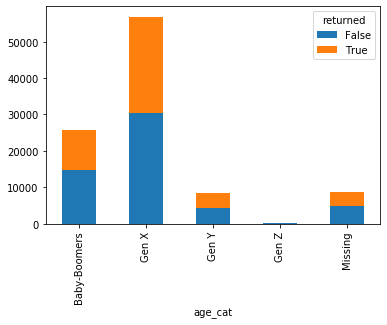

In [42]:
age = df_known.groupby(['returned', 'age_cat']).size().reset_index().pivot(columns='returned', index='age_cat', values=0)
                                                                       
age.plot(kind='bar', stacked=True);

### # of Deliveries to Each User

In [43]:
# Total number of deliveries to each user is calculated and added as a new variable
user_purchase_cnt=df_known.groupby("user_id")["item_price"].count()
user_purchase_cnt_df=user_purchase_cnt.to_frame()
user_purchase_cnt_df=user_purchase_cnt_df.rename({'item_price': 'user_purchase_cnt'}, axis=1)
df_known=df_known.merge(user_purchase_cnt_df, on="user_id", how='left')

### Total Amount of Purchases by Each User

In [44]:
# Total amount of purchases by each user is calculated and added as a new variable
user_purchase_amt=df_known.groupby("user_id")["item_price"].sum()
user_purchase_amt_df=user_purchase_amt.to_frame()
user_purchase_amt_df=user_purchase_amt_df.rename({'item_price': 'user_purchase_amt'}, axis=1)
df_known=df_known.merge(user_purchase_amt_df, on="user_id", how='left')

### # of Deliveries from Each Brand

In [45]:
# Total number of deliveries from each brand is calculated and added as a new variable
brand_purchase_cnt=df_known.groupby("brand_id")["item_price"].count()
brand_purchase_cnt_df=brand_purchase_cnt.to_frame()
brand_purchase_cnt_df=brand_purchase_cnt_df.rename({'item_price': 'brand_purchase_cnt'}, axis=1)
df_known=df_known.merge(brand_purchase_cnt_df, on="brand_id", how='left')

### # of Deliveries from Each Item

In [46]:
# Total number of deliveries from each item is calculated and added as a new variable
item_purchase_cnt=df_known.groupby("item_id")["item_price"].count()
item_purchase_cnt_df=item_purchase_cnt.to_frame()
item_purchase_cnt_df=item_purchase_cnt_df.rename({'item_price': 'item_purchase_cnt'}, axis=1)
df_known=df_known.merge(item_purchase_cnt_df, on="item_id", how='left')

### Average Amount of Purchases from Each User

In [47]:
#The average amount of purchases from each user found by dividing total user purchase amount by total #of purchases from each user.
df_known["user_purchase_avg"]=df_known["user_purchase_amt"]/df_known["user_purchase_cnt"]

Feature engineering process is concluded by the addition of these variables.The data types or the new features are determined below. Moreover, unnecessary columns such as dates are dropped to omit any inconvenience stemming from the missing data.

In [48]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 23 columns):
order_date             100000 non-null datetime64[ns]
delivery_date          90682 non-null datetime64[ns]
item_id                100000 non-null int64
item_size              100000 non-null category
item_color             100000 non-null category
brand_id               100000 non-null int64
item_price             100000 non-null float64
user_id                100000 non-null int64
user_title             100000 non-null category
user_dob               91275 non-null datetime64[ns]
user_state             100000 non-null category
user_reg_date          100000 non-null datetime64[ns]
returned               100000 non-null bool
delivery_time_weeks    100000 non-null float64
delivery_time_cat      100000 non-null object
months_since_reg       100000 non-null float64
age                    100000 non-null float64
age_cat                100000 non-null object
user_purchase_cnt      10

In [49]:
# The data types for the new variables are assigned
df_known['user_purchase_cnt'] = df_known['user_purchase_cnt'].astype('float64')
df_known['brand_purchase_cnt'] = df_known['brand_purchase_cnt'].astype('float64')
df_known['item_purchase_cnt'] = df_known['item_purchase_cnt'].astype('float64')
df_known['delivery_time_cat'] = df_known['delivery_time_cat'].astype('category')
df_known['age_cat'] = df_known['age_cat'].astype('category')

In [50]:
# The unnecassary columns are dropped
df_known=df_known.drop(["order_date","delivery_date","user_dob","user_reg_date"],axis=1)

After these steps each variable in the data except the categorical variables are handled. New variables are formed by feature engineering and in this process the null values and the data types of the variables are taken care of. The project will continue with the exploratory data analysis for all the variables that are available so far.Then, the categorical variables will be handled so that these also can be interpreted as meaningful inputs by the algorithms that will be used later on.

# Exploratory Data Analysis

In this part of the project, the features that the model has so far will be analyzed thoroughly to see whether they are satisfying the statistical properties that are needed for the algorithms. Although, the tree based algorithms that will be used in this project are fairly robust, the analysis will be realized for the sake of completeness and having a better understanding of the variables that were available and that are engineered. Univariate analysis for each feature and multivariate analysis for several features will be the main two headlines of this section.

In [51]:
df_known.head(n=5)

,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_state,returned,delivery_time_weeks,delivery_time_cat,months_since_reg,age,age_cat,user_purchase_cnt,user_purchase_amt,brand_purchase_cnt,item_purchase_cnt,user_purchase_avg
0,643,38,navy,30,49.90,30822,Mrs,Saxony,False,1.0,1,3.0,47.0,Gen X,3.0,86.25,1272.0,22.0,28.750000
1,337,152,grey,30,19.95,30822,Mrs,Saxony,False,1.0,IsMissing,3.0,47.0,Gen X,3.0,86.25,1272.0,52.0,28.750000
2,270,xxl,grey,49,79.90,30823,Mrs,Baden-Wuerttemberg,True,1.0,1,18.0,46.0,Gen X,17.0,703.30,1733.0,81.0,41.370588
3,142,xxl,grey,49,99.90,30823,Mrs,Baden-Wuerttemberg,False,1.0,1,18.0,46.0,Gen X,17.0,703.30,1733.0,228.0,41.370588
4,561,xxl,grey,3,14.90,30823,Mrs,Baden-Wuerttemberg,True,1.0,1,18.0,46.0,Gen X,17.0,703.30,11389.0,137.0,41.370588


In [52]:
df_known.describe(include="all")

,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_state,returned,delivery_time_weeks,delivery_time_cat,months_since_reg,age,age_cat,user_purchase_cnt,user_purchase_amt,brand_purchase_cnt,item_purchase_cnt,user_purchase_avg
count,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000,100000,100000,100000.000000,100000.0,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
unique,NaN,102,75,NaN,NaN,NaN,5,16,2,NaN,7.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
top,NaN,l,black,NaN,NaN,NaN,Mrs,North Rhine-Westphalia,False,NaN,0.0,NaN,NaN,Gen X,NaN,NaN,NaN,NaN,NaN
freq,NaN,12347,18640,NaN,NaN,NaN,95429,22825,54182,NaN,52905.0,NaN,NaN,56901,NaN,NaN,NaN,NaN,NaN
mean,923.781820,NaN,NaN,30.149020,65.064695,27169.073960,NaN,NaN,NaN,0.969540,NaN,10.55528,52.438090,NaN,12.209380,729.864517,3527.967000,189.169700,65.064695
std,702.568822,NaN,NaN,28.180191,47.991546,14053.417669,NaN,NaN,NaN,1.891446,NaN,7.45615,10.828495,NaN,14.597324,823.070744,3579.960827,199.000892,34.115726
min,1.000000,NaN,NaN,1.000000,0.000000,9.000000,NaN,NaN,NaN,0.000000,NaN,0.00000,5.000000,NaN,1.000000,0.000000,1.000000,1.000000,0.000000
25%,214.000000,NaN,NaN,5.000000,29.900000,14937.000000,NaN,NaN,NaN,0.000000,NaN,3.00000,47.000000,NaN,4.000000,239.600000,952.000000,60.000000,42.207692
50%,812.000000,NaN,NaN,25.000000,49.900000,31189.000000,NaN,NaN,NaN,0.000000,NaN,10.00000,52.000000,NaN,8.000000,474.600000,1829.000000,128.000000,56.983333
75%,1581.000000,NaN,NaN,44.000000,79.900000,38917.250000,NaN,NaN,NaN,1.000000,NaN,19.00000,57.000000,NaN,15.000000,888.200000,4716.000000,232.000000,78.614286


### Univariate Analysis

In [53]:
print("The mean values for returned and non-returned items: \n")
print(df_known.groupby("returned")[["delivery_time_weeks","months_since_reg","age"]].mean())
print(df_known.groupby("returned")[["user_purchase_cnt","user_purchase_amt","brand_purchase_cnt","item_purchase_cnt","user_purchase_avg"]].mean())

The mean values for returned and non-returned items: 

          delivery_time_weeks  months_since_reg        age
returned                                                  
False                0.995884         10.377487  52.722694
True                 0.938387         10.765529  52.101532
          user_purchase_cnt  user_purchase_amt  brand_purchase_cnt  \
returned                                                             
False             11.791960         669.412858         3672.111568   
True              12.702999         801.351527         3357.509079   

          item_purchase_cnt  user_purchase_avg  
returned                                        
False            194.523107          61.542937  
True             182.839037          69.229345  


The univariate analysis of the numerical features show that there are significant differences between returned and nonreturned items in terms of these variables. To better illustrate, one can see that while an item that is not returned is purchased 194.52 times on average, an item that is returned is purchased only 182.83 times on average. Similar differences are observed for the user_purchase_avg, brand_purchase_cnt, user_purchase_amt columns. Although for the other columns this difference might not be seemed as too significant, further analysis of these variables should be taken into account.

In [54]:
print("The unique values and their value counts for each categorical variable: \n")
print(df_known.item_size.value_counts(),df_known.item_color.value_counts(),df_known.user_title.value_counts(),
      df_known.user_state.value_counts(),df_known.delivery_time_cat.value_counts(),df_known.age_cat.value_counts(), sep="\n\n")

The unique values and their value counts for each categorical variable: 

l       12347
xl      10979
m       10190
xxl      8966
40       7693
        ...  
84          1
105         1
3634        1
4034        1
49          1
Name: item_size, Length: 102, dtype: int64

black          18640
blue           10851
brown           8747
grey            8708
red             7264
               ...  
copper coin        7
amethyst           5
avocado            4
creme              4
opal               2
Name: item_color, Length: 75, dtype: int64

Mrs             95429
Mr               3915
Family            414
Company           128
not reported      114
Name: user_title, dtype: int64

North Rhine-Westphalia           22825
Lower Saxony                     15149
Bavaria                          13672
Baden-Wuerttemberg               11981
Hesse                             7586
Schleswig-Holstein                5531
Rhineland-Palatinate              4784
Berlin                            4093

In these tables, one can see the unique values and their counts for each categorical feature. While features such as item_size and item_color have a lot of distinct levels, other variables such as age_cat, delivery_time_cat, user_state and user_title have lower number of distinct levels. This will mainly shape our approach to these variables in the future.

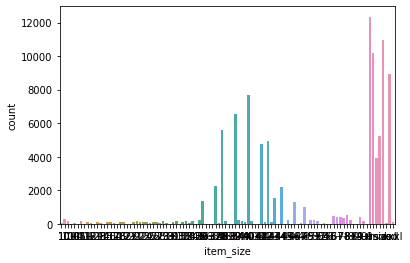

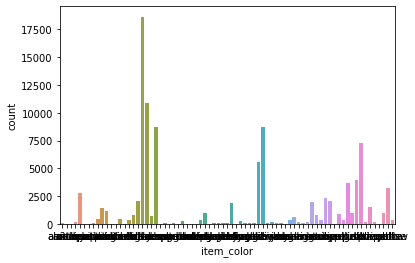

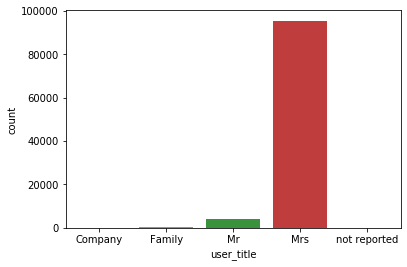

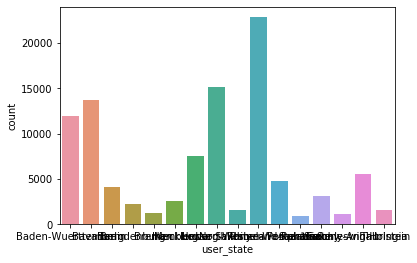

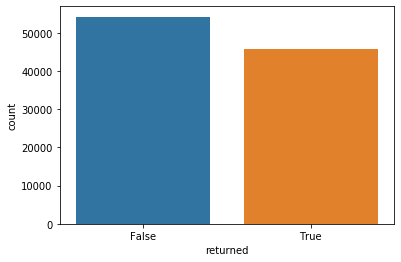

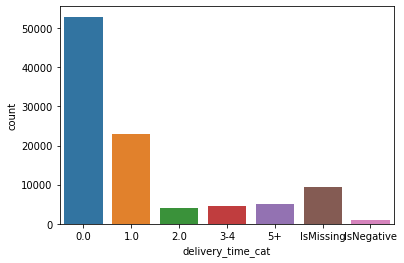

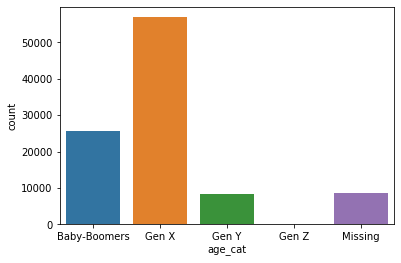

In [55]:
#Creating countplots for each categorical and boolean variable
for i, col in enumerate(df_known.select_dtypes(include=['category',"bool"]).columns):
    plt.figure(i)
    sns.countplot(x=col, data=df_known)

In these countplots one can basically realize that the number of purchases between different category levels vary significantly. The labeled data is fairly balanced in terms of returned and non-returned items. The item_size and item_color features have so many different levels as mentioned earlier.

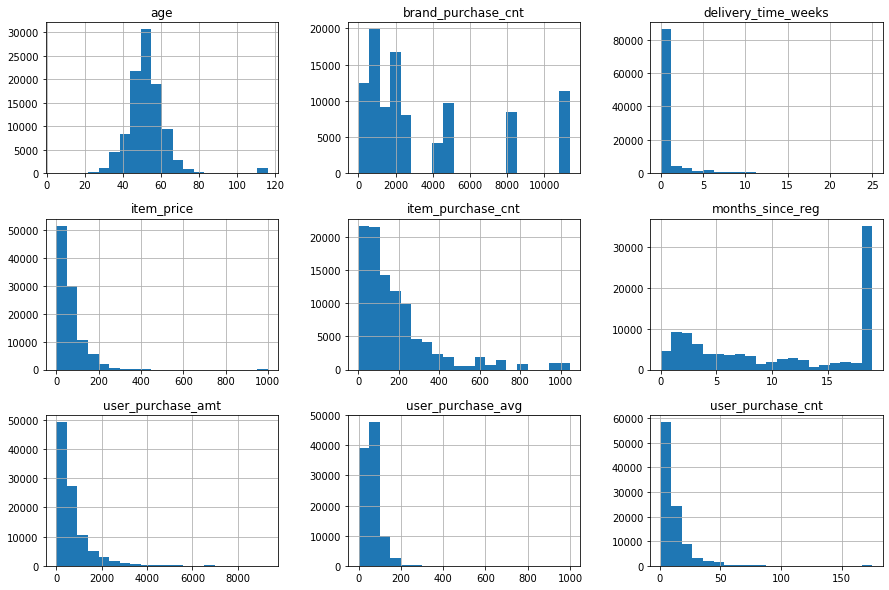

In [56]:
#Creating histograms for each numeric variable
df_known.select_dtypes(include='float64').hist(bins=20,figsize=(15, 10));

Most of the data except the age seems to be highly skewed. The data could be normalized or even standardized by using libraries such as scikit-learn. However, since tree based models(XGB, RFC) are robust to the distrubition of the data this step is unnecessary. Furthermore, the interpretability of the variables are seemed to be more important since standardizing does not effect the outcome much. Therefore, the data will not be standardized.

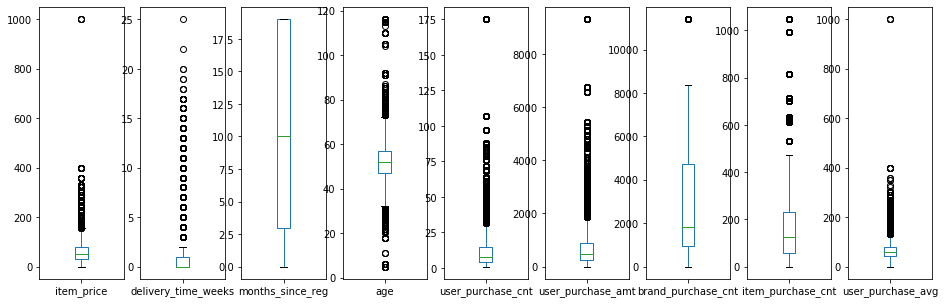

In [57]:
#Creating boxplots for each numeric variable
df_known.select_dtypes(include="float64").plot(kind = 'box', subplots=True,figsize=(16, 5));

As one can see here, variables such as delivery_time_weeks and age seem to have a large portion of outliers. However, these were already handled by discretization of the variables. Since they also had a fairly big amount of missing values handling these two variables by discretizing actually makes sense. For the other variables, the tree based algorithms are usually robust to outliers. Furthermore, the data we have is actually valuable and transformations such as Tukey's would lead them to be repressed to a certain number which might lead to a worse outcome. Therefore, these values will not be handled.

### Multivariate Analysis

(13.0, 0.0)

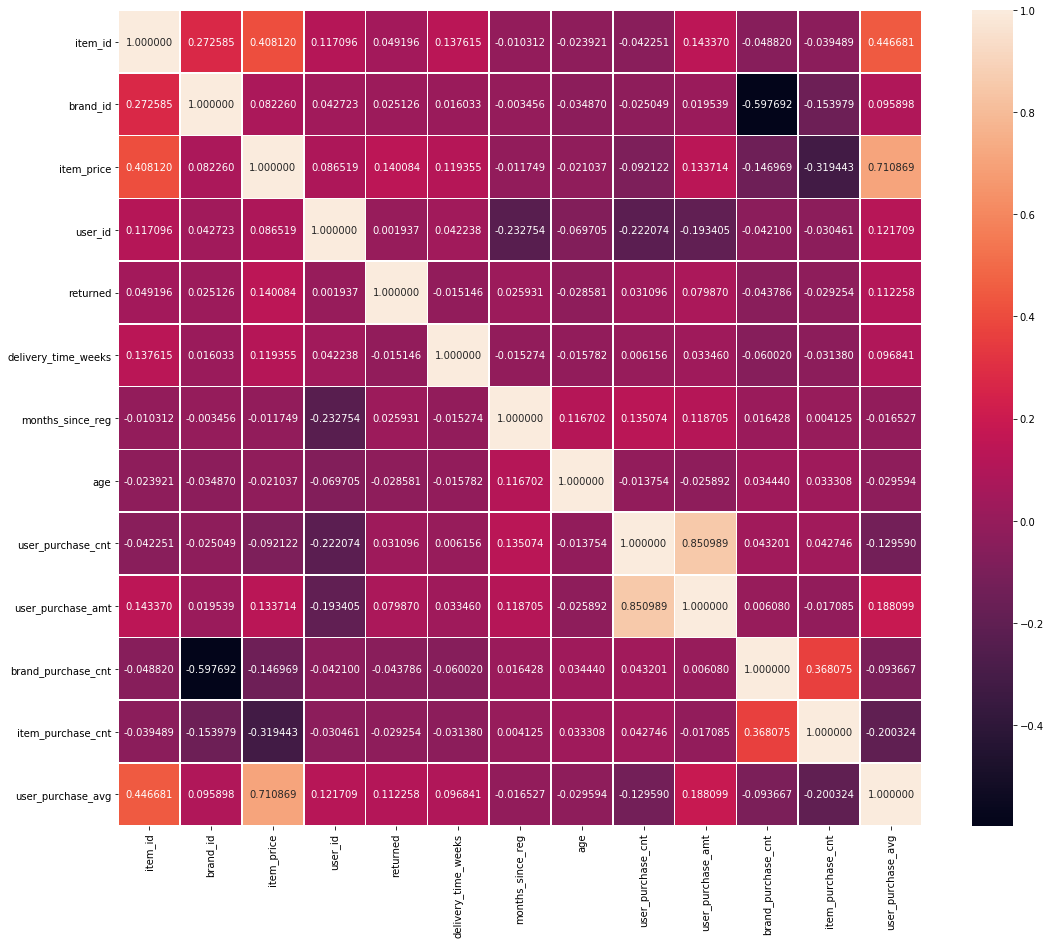

In [58]:
#Correlation of numerical variables by heatmap
corr= df_known.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');
#The top and bottom of the y axis is calibrated so that table seems complete.(A problem about the matplotlib version is handled)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(13.0, 0.0)

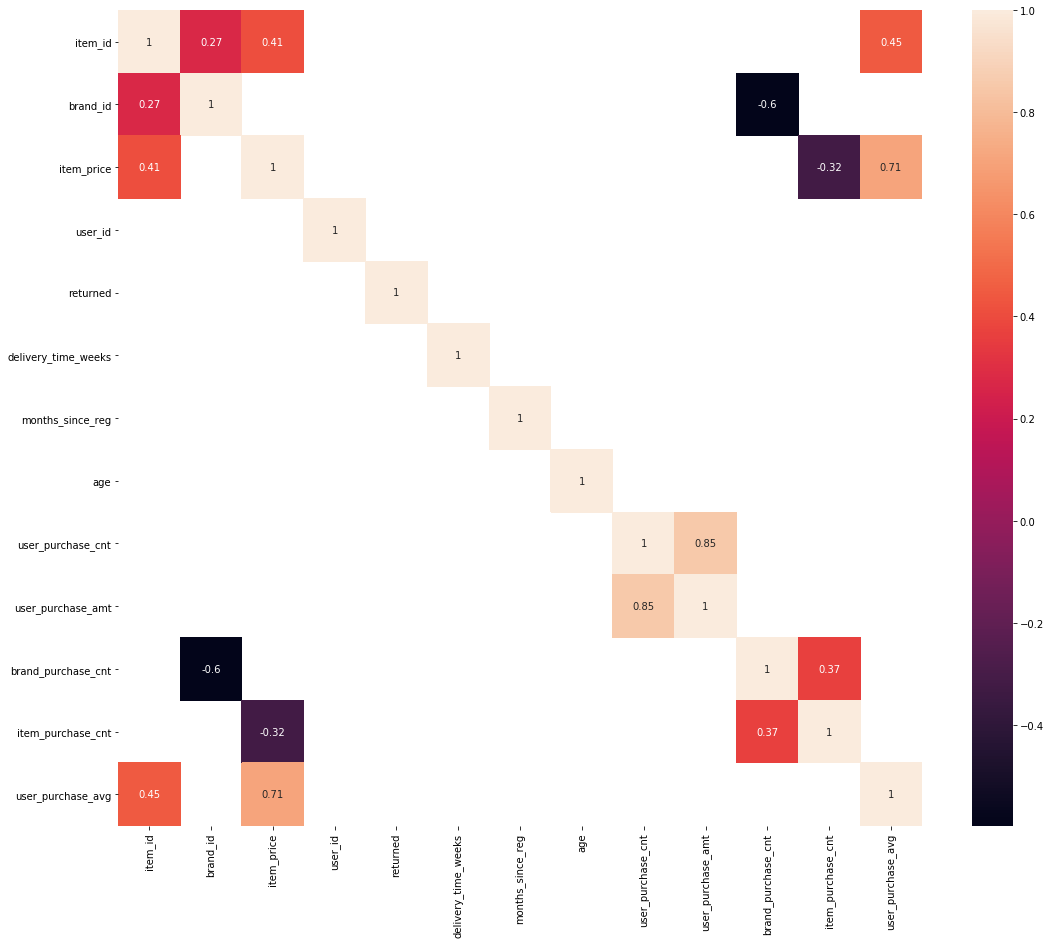

In [59]:
#Correlation of numerical variables by heatmap(only values >0.25 & <-0.25 are taken into account this time.)
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.25) | (corr <= -0.25)],
            annot=True);
#The top and bottom of the y axis is calibrated so that table seems complete.(A problem about the matplotlib version is handled)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Since the first correlation map is harder to interpret, one may take a look at the second map where the variables with correlation higher than 0.25 or lower than -0.25 are only seen. This map shows that some variables are highly correlated with others. One example for these might be user_purchase_cnt and user_purchase_amt which is expected. The more purchase a user makes, the more amount in terms of money s/he will have purchased. However the models that will be used in this project that are namely XGB and RFC are fairly robust to multicollinearety. Therefore the variables will be kept.

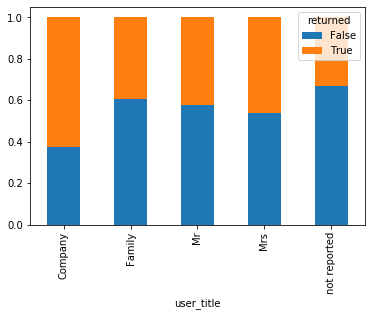

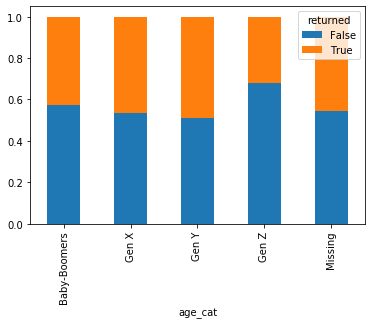

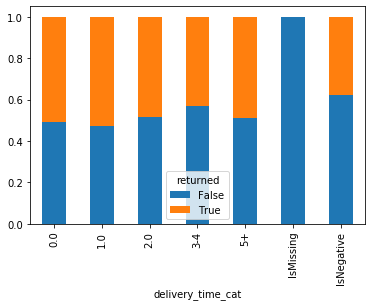

In [60]:
#Frequency plots for categorical variables
user_title = df_known.groupby(['returned', 'user_title']).size().reset_index().pivot(columns='returned', index='user_title', values=0)
user_title.div(user_title.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

age_cat = df_known.groupby(['returned', 'age_cat']).size().reset_index().pivot(columns='returned', index='age_cat', values=0)
age_cat.div(age_cat.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

delivery_time_cat = df_known.groupby(['returned', 'delivery_time_cat']).size().reset_index().pivot(columns='returned', index="delivery_time_cat", values=0)
delivery_time_cat.div(delivery_time_cat.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

The frequency plots for the categorical features that have low number of category levels show that the returned proportions seems to differ between categories of the categorical variables. Therefore discretizing seems to work well for this particular problem especially for the delivery_time and age.

## Encoding Categorical Features and Splitting the Data

Before creating the models one of the common steps is encoding the categorical features. For this part, two seperate approaches are adapted according to the feature characteristics. The variables that have low number of categories are encoded via one hot encoding method. The variables with higher number of categories on the other hand such as item_size and item_color are encoded via weight of evidence method. The weight of evidence encoding becomes more preferable when the large number of categories is high in order not to create a dataframe with a greater number of columns that would yield a poorer performance during the modeling part. For the user_state column both WoE and OHEC approaches are adopted seperately and OHEC yielded a better result.

In [61]:
#Weight of evidence for item color and item size
bins = sc.woebin(df_known, y="returned", x=['item_color', 'item_size'])

[INFO] creating woe binning ...
>>> There are 2 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
item_color, item_size
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 100000 rows and 3 columns in 00:00:16


In [62]:
#Replacing the columns of item color and item size with the encoded variables
df_known_new =sc.woebin_ply(df_known, bins)

[INFO] converting into woe values ...


Normally, it is a bad practice to use weight of evidence encoding before splitting the data into train and test sets since the test set should not know the labels before encoding. However, for this particular case the model encoded with all of the known data showed a good performance on Kaggle. Since our main aim for now is to select a good model and tune it, approaching the problem in this way would not be harmful. Instead of using two seperate encoding for validation and test sets, this might be even be a better practice, given the high number of categories for item size and item color.

In [63]:
#Replacing the colomns of delivery time user title age and user state by their dummies
df_known=pd.get_dummies(df_known_new, columns = ['delivery_time_cat', 'user_title',"age_cat","user_state"], drop_first=True)

In [64]:
#To check whether the dataframe is successfully formed
df_known.head(n=5)

,brand_purchase_cnt,brand_id,item_purchase_cnt,returned,months_since_reg,item_price,user_id,user_purchase_amt,item_id,delivery_time_weeks,...,user_state_Hesse,user_state_Lower Saxony,user_state_Mecklenburg-Western Pomerania,user_state_North Rhine-Westphalia,user_state_Rhineland-Palatinate,user_state_Saarland,user_state_Saxony,user_state_Saxony-Anhalt,user_state_Schleswig-Holstein,user_state_Thuringia
0,1272.0,30,22.0,False,3.0,49.90,30822,86.25,643,1.0,...,0,0,0,0,0,0,1,0,0,0
1,1272.0,30,52.0,False,3.0,19.95,30822,86.25,337,1.0,...,0,0,0,0,0,0,1,0,0,0
2,1733.0,49,81.0,True,18.0,79.90,30823,703.30,270,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1733.0,49,228.0,False,18.0,99.90,30823,703.30,142,1.0,...,0,0,0,0,0,0,0,0,0,0
4,11389.0,3,137.0,True,18.0,14.90,30823,703.30,561,1.0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
#The data is partitioned into features and labels
X = df_known.drop(['returned'], axis=1) 
y = df_known[['returned']]

In [66]:
#The train set and the validation set is formed
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Model Selection and Tuning

In order to solve this binary classification problem, ensemble learning algorithms Extreme Gradient Boosting and Random Forest Classifier are used. Ensemble learners outperform algorithms such as logit or a decision tree since they are basically consisting of multiple layers of these algorithms. 

There are also various benefits of using tree based algorithms in addition to their outstanding performances. First of all, normalization or standardization of the variables are not necessary for these algorithms since they are solely interested in the split points regardless of the distribution. Moreover, they are robust to multicollinearity which means that there is no need for elimination of the correlated variables. Furthermore, the algorithms are usually robust to outliers. Finally, for the cost sensitive learning tree based algorithms are known to be working well with the Bayes decision to minimize the costs which will be the specific approach in this notebook.

Initially, some preliminary hyperparemeters are used for the analysis of both models. Although, these hyperparameter values were not analyzed thoroughly since this will be carried out in the model tuning part, some logical assumptions and elimination techniques are used to eliminate options and reduce the runtime. To better illustrate, there were 3x3x2x2x1 hyperparameter options for XGB that was tried out in a setting with 5 crossfolds in preliminary analysis. However this yielded a runtime of 75 minutes which was highly costly. From this point on, the parameter values were eliminated in a local way instead of a global approach. Some of the parameters yielded the best result in all different combinations and therefore they were fixed such as 0.01 learning rate. The last parameter grid that is used for this preliminary analysis for XGB and RFC can be seen in the following sections. Further improvements will be made in the chosen model in the hyperparameter tuning part.

## XGBoost

In [67]:
# The grid of meta-parameters are set up
xgb_param_grid1 = {
    'colsample_bytree': [0.7,0.9] ,
    'n_estimators': [100],
    'max_depth': [5,10],
    'learning_rate': [0.01],
    'early_stopping_rounds': [10],
}

In [68]:
# Set up the grid object specifying the tuning options
gs_xgb1 = GridSearchCV(estimator=xgb.XGBClassifier(njobs=-1,random_state=123), param_grid=xgb_param_grid1, scoring='roc_auc', cv=3, verbose=2)
gs_xgb1.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:38:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=   8.4s
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 
[17:38:57] WARNING: C:/Users/Administrator/workspace/xgboost-

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:38:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=   8.6s
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 
[17:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=  10.0s
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  19.7s
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  15.8s
[CV] colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:39:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.7, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  15.7s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 
[17:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=   7.5s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 
[17:40:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=   8.1s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100 
[17:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=5, n_estimators=100, total=   7.4s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:40:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  17.9s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  17.7s
[CV] colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100 
[17:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.9, early_stopping_rounds=10, learning_rate=0.01, max_depth=10, n_estimators=100, total=  18.3s
[17:41:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { early_stopping_rounds, njobs } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.6min finished
C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=

In [69]:
# The best AUC score in cross validations and optimal parameters
print("Best CV AUC: %0.4f" % gs_xgb1.best_score_)
print("Optimal XGB meta-parameters:")
print(gs_xgb1.best_params_)

Best CV AUC: 0.7311
Optimal XGB meta-parameters:
{'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}


In [70]:
# Find test set AUC of the best XGB classifier
fp_rate_xgb1, tp_rate_xgb1, _ = metrics.roc_curve(y_val, gs_xgb1.predict_proba(X_val)[:, 1])
print('XGB test set AUC with optimal meta-parameters: {:.4f}'.format(metrics.auc(fp_rate_xgb1, tp_rate_xgb1) ))

XGB test set AUC with optimal meta-parameters: 0.7422


## Random Forest Classifier

In [71]:
rf = RandomForestClassifier(n_jobs=-1,random_state=123)

# The grid of meta-parameters are set up
rf_param_grid1 = {'n_estimators': [100,110],
              'max_features': [4, 5]
              }

In [72]:
# Set up the grid object specifying the tuning options
gs_rf1 = GridSearchCV(rf, rf_param_grid1, cv=3, scoring='roc_auc', verbose=1)
gs_rf1.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'m

In [73]:
print("Best CV AUC: %0.4f" % gs_rf1.best_score_)
print("Optimal RFC meta-parameters:")
print(gs_rf1.best_params_)

Best CV AUC: 0.7333
Optimal RFC meta-parameters:
{'max_features': 5, 'n_estimators': 110}


In [74]:
auc_trace1 = {}

# Find test set auc of the best random forest classifier
fp_rate_rf1, tp_rate_rf1, _ = metrics.roc_curve(y_val, gs_rf1.predict_proba(X_val)[:, 1])
auc_trace1.update( {'rf' : metrics.auc(fp_rate_rf1, tp_rate_rf1)}) 
print('RFC test set AUC: {:.4f}'.format(auc_trace1['rf']))

RFC test set AUC: 0.7461


## Comparison of XGB and RFC

In this part, firstly the models were fitted. This time instead of using grid search, using the best parameters that are found are used. The main reason for this is to make use of some of the functionalities that are not possible using grid search. There is one exception about the best parameters which is the max_depth used in XGB. When the feature importances for both models are analyzed, the delivery_time_cat_Ismissing seems to be playing an important role in XGB Algorithm. As max depth increases, the AUC score of XGB also increases but this time the model overfits for the missing values of delivery time. Since previous analysis showed that in the train data, every missing value for delivery time yielded a non_returned item, the performance of XGB significantly changes by this behavior. However, there are no missing values for delivery time in the unknown data which will be analyzed later. Therefore the maximum depth of trees in XGB model is set to 5 which would yield a more realistic performance of the model.

In [75]:
#Creating an array of variable labels. (This will be later used for feature importances of both models.)
X_var_labels = X_train.columns[0:X_train.shape[1]]

In [76]:
#Fitting the XGB model with best params except max_depth!
xgb2 = XGBClassifier(
    max_depth=5, n_estimators=100,  learning_rate = 0.01, colsample_bytree = 0.7, use_label_encoder=False, random_state= 123)
xgb2.fit(X_train, y_train.values.ravel())

[17:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [77]:
#Fitting the RFC model with best params
rf2 = RandomForestClassifier(n_estimators=110, max_features=4, random_state = 123) 
rf2.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

The feature importances of the XGB model: 



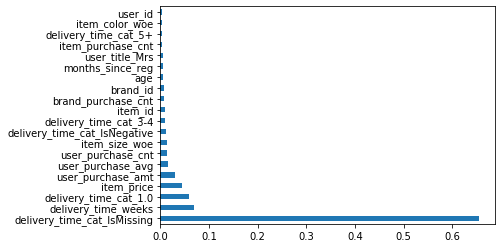

In [78]:
# Feature importance XGB
print("The feature importances of the XGB model: \n")
feat_importances_xgb = pd.Series(xgb2.feature_importances_, index= X_var_labels)
feat_importances_xgb.nlargest(20).plot(kind='barh');

The feature importances of the RF model: 



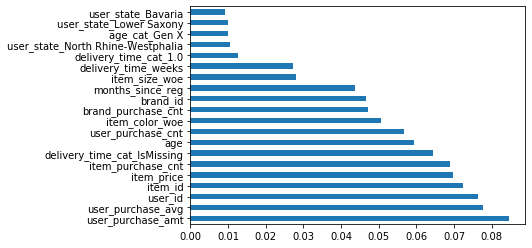

In [79]:
# Feature importance RFC
print("The feature importances of the RF model: \n")
feat_importances_rf = pd.Series(rf2.feature_importances_, index= X_var_labels)
feat_importances_rf.nlargest(20).plot(kind='barh');

In [80]:
print('XGB AUC is: {:.4}'.format(roc_auc_score(y_val, xgb2.predict_proba(X_val)[:,1])))
print('RFC AUC is: {:.4}'.format(roc_auc_score(y_val, rf2.predict_proba(X_val)[:,1])))

XGB AUC is: 0.7149
RFC AUC is: 0.7466


The AUC scores of the both models with best parameters show a significant difference. The RFC seems to overperform compared to XGB significantly. Moreover RFC seems to be more robust giving less importance to the missing values in the delivery time. However, further analysis will be carried out. Confusion matrix and the metrics related to it are analyzed below. In this problem, the returned items belong to the positive class(1) while nonreturned items belong to the negative class(0).

Note: The labels are slightly different from the lecture notes. Predicted values are on x axis while real outcomes are on y axis. The confusion matrix is formed with the help of the following blog post: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

(2.0, 0.0)

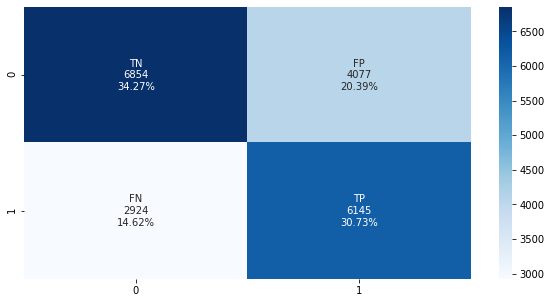

In [81]:
#The confusion matrix for the XGB is formed
cmat = metrics.confusion_matrix(y_val, xgb2.predict(X_val)) 
plt.figure(figsize=(10,5))
group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                cmat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmat.flatten()/np.sum(cmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cmat, annot=labels, fmt="", cmap='Blues')

#The top and bottom of the y axis is calibrated so that table seems complete.(A problem about the matplotlib version is handled)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(2.0, 0.0)

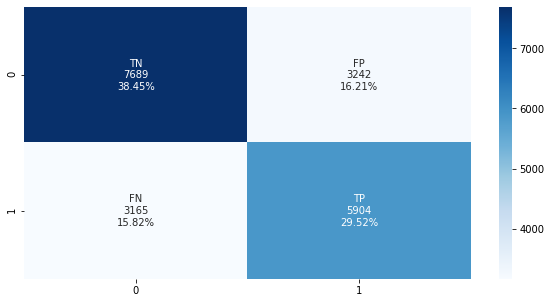

In [82]:
#The confusion matrix for the RFC is formed
cmat2 = metrics.confusion_matrix(y_val, rf2.predict(X_val))
plt.figure(figsize=(10,5))
group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                cmat2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmat2.flatten()/np.sum(cmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cmat2, annot=labels, fmt="", cmap='Blues')

#The top and bottom of the y axis is calibrated so that table seems complete.(A problem about the matplotlib version is handled)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The RFC yields a smaller FPR while XGB is slightly better in terms of FNR. However, since both of the false predictions FN and FP yield costs for the company further analysis should be taken into account. As a preliminary analysis, one can say that a false positive is usually more costly because of the higher coefficient in front of the item_price in the cost matrix. However, this issue will be analyzed in a more detailed fashion in the model evaluation part.

In [83]:
df_pred= pd.DataFrame(columns = ["p_xgb","p_rf"])
df_pred["p_xgb"]=xgb2.predict_proba(X_val)[:,1]
df_pred["p_rf"]=rf2.predict_proba(X_val)[:,1]

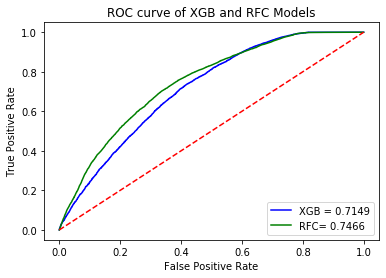

In [84]:
# The ROC curve is manually plotted.
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_val,df_pred["p_xgb"].values) 
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_val,df_pred["p_rf"].values)

# Compute AUC
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb) 
auc_rf = metrics.auc(fpr_rf, tpr_rf)

# ROC curve
plt.plot(fpr_xgb, tpr_xgb, "b", label="XGB = %0.4f" % auc_xgb)
plt.plot(fpr_rf, tpr_rf, "b", label="RFC= %0.4f" % auc_rf, color='green')

# Random benchmark
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC curve of XGB and RFC Models')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

The ROC Curve of RFC is outperforming the XGB for most of the thresholds as the graph above illustrates. Moreover the AUC score of RFC is also significantly higher. The previous analysis also concluded that the RFC is a more robust option. Therefore, RFC is chosen as the best model while entering to the hyperparameter tuning section.

# Hyperparameter Tuning for RFC Model

The approach that is carried out in this step is heavily influenced by the following post: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.
The adopted strategy consists of two steps. In the first step the tuning a random search is carried out with cross validation.  The benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values which significantly reduces the cost while giving us a good starting point for grid search. After evaluating the random search, a grid search with cross validation is carried out to reach the optimum values for the hyperparameters.

In [85]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
# Number of features to consider at every split
max_features = [4,5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               }
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': [4, 5]}


In [86]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1, 

In [87]:
print('RFC AUC after random search is: {:.4}'.format(roc_auc_score(y_val, rf_random.predict_proba(X_val)[:,1])))
print("Optimal RFC meta-parameters after random search:")
print(rf_random.best_params_)

RFC AUC after random search is: 0.7491
Optimal RFC meta-parameters after random search:
{'n_estimators': 300, 'max_features': 4}


In [88]:
# Determining the optimal parameter grid
param_grid = {
    'max_features': [4, 5],
    'n_estimators': [200, 250, 300]
}

In [89]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max

In [90]:
print('RFC AUC after grid search is: {:.4}'.format(roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1])))
print("Optimal RFC meta-parameters after grid search:")
print(grid_search.best_params_)

RFC AUC after grid search is: 0.7495
Optimal RFC meta-parameters after grid search:
{'max_features': 5, 'n_estimators': 300}


After the hyperparameter tuning part the AUC score of the model has increased significantly as the above analysis shows. Although it might be possible to increase it even further by increasing the number of estimators, it is not suggested for mainly one reason. It increases the computational complexity and therefore the cost of the model. In order to reduce the runtime for GridSearch(), 300 is determenined to be a good cutoff point since the marginal contribution of the AUC score seemed to be slightly improving the model afterwards.

## Post Processing for Cost Sensitivity

Until now, only the AUC scores of the models are taken into account for model improvement. In order to make the model cost sensitive, the RFC model will be combined with Bayes decision theory. This way, case specific threshold values will be achieved to assign each case into a return or a non-return which will minimize the costs. Then the base model with 0.5 cutoff will be compared with the cost sensitive model to analyze the improvement in terms of cost.

In [91]:
# The random forest classifier with optimal parameters is chosen.
rf_best = RandomForestClassifier(n_estimators=300, max_features=5, random_state = 123) 
rf_best.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In this part of the project, The Foundations of Cost-Sensitive Learning by Charles Elkan was followed in order to make optimal decisions. The probability of an item being returned is multiplied by the cost of predicting false negatives to find out the expected costs of predicting 0 incorrectly. On the other hand the probability of an item being non-returned is multipled by the cost of predicting false positive to find out the expected costs of predicting 1 incorrectly. The expected costs are compared to come up with an optimal solution.

In [92]:
# The probabilities of return and non-return are put into a dataframe.
probs=rf_best.predict_proba(X_val)
df = pd.DataFrame(probs, columns =['prob_0', 'prob_1']) 

# The prices of the items are also added since they exist in the cost matrix.
prices=X_val.item_price.reset_index().drop("index",axis=1)
df["item_price"]=prices

# The FP and FN costs are calculated according to the cost matrix.
df["FP_cost"]=df.item_price/2
df["FN_cost"]=7.5+0.25*df.item_price

# The expected cost of predicting zero and predicting 1 is calculated for each case.
df["cost_pred_0"]=df.FN_cost*df["prob_1"]
df["cost_pred_1"]=df.FP_cost*df["prob_0"]

# The decision of base model and the cost sensitive model is added into the dataframe.
df['Y_hat_base'] = np.where((df["prob_1"] > 0.5) #The base model assigns 1 whenever prob_1 is greater than 0.5
                     ,1,0)
df['Y_hat_cost'] = np.where((df["cost_pred_0"] > df["cost_pred_1"]) #The cost sensitive model assigns 1 whenever cost of predicting 1 is smaller.
                     ,1,0)

In [93]:
df.head(n=20)

,prob_0,prob_1,item_price,FP_cost,FN_cost,cost_pred_0,cost_pred_1,Y_hat_base,Y_hat_cost
0,0.903333,0.096667,21.90,10.950,12.9750,1.254250,9.891500,0,0
1,0.900556,0.099444,0.00,0.000,7.5000,0.745833,0.000000,0,1
2,0.486667,0.513333,99.90,49.950,32.4750,16.670500,24.309000,1,0
3,0.578889,0.421111,69.90,34.950,24.9750,10.517250,20.232167,0,0
4,0.706667,0.293333,19.90,9.950,12.4750,3.659333,7.031333,0,0
5,0.599167,0.400833,59.90,29.950,22.4750,9.008729,17.945042,0,0
6,0.586667,0.413333,99.90,49.950,32.4750,13.423000,29.304000,0,0
7,0.943333,0.056667,6.90,3.450,9.2250,0.522750,3.254500,0,0
8,0.671111,0.328889,54.90,27.450,21.2250,6.980667,18.422000,0,0
9,0.430556,0.569444,59.90,29.950,22.4750,12.798264,12.895139,1,0


Analyzing the table above one might see that the cost sensitive model is more inclined to predict that the item will be returned("1") whenever the item_price is low. On the other hand, as the item_price increases it changes the behavior of cost sensitive model to make more ("0") decisions. This outcome mainly stems from the properties of the cost matrix. It becomes too costly to predict 1 after a certain price.

In [94]:
# The validation labels are also added in order to find out whether model predicts a FP or FN.
Y_real=y_val.returned.reset_index().drop("index",axis=1)
df["Y_real"]=Y_real
df["Y_real"] = df["Y_real"].astype(int)

In [95]:
# The base model costs are found out.
conditions = [
    (df['Y_hat_base'] > df['Y_real']), 
    df['Y_hat_base'] < df['Y_real']]

choices = [df['FP_cost'], df['FN_cost']]

df['Base_Cost'] = np.select(conditions, choices, default=0)

Whenever the base model predicts 1 and the real model predicts 0, Y_hat_base > Y_real. Therefore, in this instance a false positive would be achieved and the related cost would be taken into account. On the other hand, when Y_hat_base < Y_real,a false negative case would be achieved. The related costs are added in a new column named "Base_Cost" which stands for the total cost of the base model when the cutoff was determined as 0.5. The same procedure is followed for the cost sensitive model below. This time the results are stored in "Cost_Cost" column which stands for the total cost of the cost sensitive model.

In [96]:
# The cost sensitive model costs are found out.
conditions2 = [
    (df['Y_hat_cost'] > df['Y_real']), 
    df['Y_hat_cost'] < df['Y_real']]

choices2 = [df['FP_cost'], df['FN_cost']]

df['Cost_Cost'] = np.select(conditions2, choices2, default=0)

# Model Evaluation

Since the AUC and ROC analysis have been thoroughly carried out until this part of the project, the confusion matrix and related metrics and the cost will be analyzed in this part.

In [97]:
print('Total cost of base model is: {:.2f}'.format(df.Base_Cost.sum()))
print('Total cost of cost sensitive model is: {:.2f}'.format(df.Cost_Cost.sum()))

Total cost of base model is: 194598.10
Total cost of cost sensitive model is: 181897.75


As it is seen above, the cost sensitive model has reduced the cost of the model significantly. Now that, the optimal cost sensitive model is chosen, the model might be reevaluated for other metrics according to the new predictions.

(2.0, 0.0)

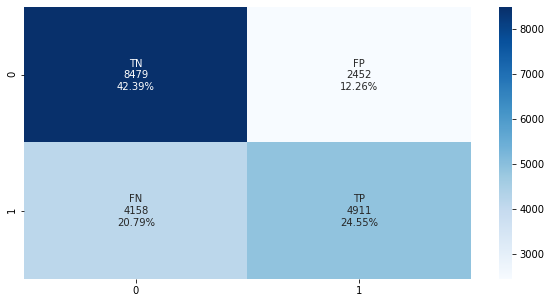

In [98]:
#The confusion matrix for the RFC is formed
cmat3 = metrics.confusion_matrix(y_val, df.Y_hat_cost)
plt.figure(figsize=(10,5))
group_names = ["TN","FP","FN","TP"]
group_counts = ["{0:0.0f}".format(value) for value in
                cmat3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cmat3.flatten()/np.sum(cmat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cmat3, annot=labels, fmt="", cmap='Blues')

#The top and bottom of the y axis is calibrated so that table seems complete.(A problem about the matplotlib version is handled)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

The false positive rate is seemed to be further decreased when the model is tuned in a cost sensitive fashion. On the other hand, the FN rate has increased significantly. This proves that predicting a "false positive" is more costly on average compared to predicting a "false negative". Therefore, RFC proves to be a better option once more. In a more technical way, the model performs worse in terms of recall which can be seen below but it performs significantly better in terms of precision which yields a better cost.

In [99]:
print('Accuracy of the model is: {:.4f}'.format((cmat3[1,1]+cmat3[0,0])/np.sum(cmat3)))
print('Precision is: {:.4f}'.format(cmat3[1,1]/(cmat3[1,1]+cmat3[0,1])))
print('Recall is: {:.4f}'.format(cmat3[1,1]/(cmat3[1,1]+cmat3[1,0])))

Accuracy of the model is: 0.6695
Precision is: 0.6670
Recall is: 0.5415


# Conclusions

The table below shows the performance comparison between the XGB, RFC and the tuned RFC model. The comparison is made according to three metrics. The AUC Score seems to increase significantly when RFC model is used and tuned. The precision is also increasing evidently. Precision is determined as an important performance measure since as precision increases, the model predicts less false positives which reduces the cost significantly as the previous analysis showed.  Accuracy of the RFC model is also higher than the XGB model which proves its superior predictive performance. Although the tuning of the model decreases the accuracy, the tuned model seems to perform better overall since the main performance criteria would be the cost of the model. In addition to these attributes, the RFC model seemed to be more robust in terms of the best features that the model takes into account as expressed before. The ROC curve of the RFC model also highly dominates the XGB model. No further analysis was needed to conclude that RFC outperforms XGB for this specific task.

In [155]:
#A quick comparison of XGB, RFC and tuned RFC in terms of AUC score and Recall
data = [['Model','AUC_Score','Precision','Accuracy'],["XGB",roc_auc_score(y_val, xgb2.predict_proba(X_val)[:,1]),cmat[1,1]/(cmat[1,1]+cmat[0,1]),(cmat[1,1]+cmat[0,0])/np.sum(cmat)], ["RFC",roc_auc_score(y_val, rf2.predict_proba(X_val)[:,1]),cmat2[1,1]/(cmat2[1,1]+cmat2[0,1]),(cmat2[1,1]+cmat2[0,0])/np.sum(cmat2)], ["RFC_tuned",roc_auc_score(y_val, grid_search.predict_proba(X_val)[:,1]),cmat3[1,1]/(cmat3[1,1]+cmat3[0,1]),(cmat3[1,1]+cmat3[0,0])/np.sum(cmat3)]]
print(tabulate(data, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════╤═════════════╤═════════════╤════════════╕
│ Model     │   AUC_Score │   Precision │   Accuracy │
╞═══════════╪═════════════╪═════════════╪════════════╡
│ XGB       │    0.714925 │    0.601154 │    0.64995 │
├───────────┼─────────────┼─────────────┼────────────┤
│ RFC       │    0.746643 │    0.645528 │    0.67965 │
├───────────┼─────────────┼─────────────┼────────────┤
│ RFC_tuned │    0.749472 │    0.666984 │    0.6695  │
╘═══════════╧═════════════╧═════════════╧════════════╛


After tuning the model one last step was to transform the model into a cost sensitive one. Bayes decision rule was followed for this case in a case specific manner. The assigning process of labels was explained thoroughly in the post processing part. The table below shows that the cost sensitive model outperforms the base model in terms of cost which completes our discussion. The final model to predict the outcome is determined.

In [113]:
#A quick comparison of base and cost sensitive model in terms of cost
data2=[["Model","Cost"],["Base Model",df.Base_Cost.sum()],["Cost Sensitive Model",df.Cost_Cost.sum()]]
print(tabulate(data2, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════╤════════╕
│ Model                │   Cost │
╞══════════════════════╪════════╡
│ Base Model           │ 194598 │
├──────────────────────┼────────┤
│ Cost Sensitive Model │ 181898 │
╘══════════════════════╧════════╛


# TEST SET

## Data Preprocessing

In this part of the project, the steps that are followed for the train and validation sets will be repeated for the test set in order to come up with cost sensitive predictions. Since, the steps are basically same except additional data cleaning for item size categories, the operations will not be explained thorougly like before. 

In [115]:
#Test data is read
df_unknown = pd.read_csv(r'C:\Users\Berkay Kocak\Desktop\BADS Assignment\BADS_WS2021_unknown.csv', index_col='order_item_id')

In [116]:
#It is discovered that there are some typos regarding the colors of the items.These mistakes are handled.
df_unknown.item_color[df_unknown["item_color"]=="blau"] = "blue"
df_unknown.item_color[df_unknown["item_color"]=="brwon"] = "brown"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [117]:
df_unknown.item_size[df_unknown["item_size"]=="110"]="unsized"
df_unknown.item_size[df_unknown["item_size"]=="122"]="unsized"
df_unknown.item_size[df_unknown["item_size"]=="4232"]="unsized"
df_unknown.item_size[df_unknown["item_size"]=="95"]="unsized"
df_unknown.item_size[df_unknown["item_size"]=="L"]="l"
df_unknown.item_size[df_unknown["item_size"]=="M"]="m"
df_unknown.item_size[df_unknown["item_size"]=="S"]="s"
df_unknown.item_size[df_unknown["item_size"]=="XL"]="xl"
df_unknown.item_size[df_unknown["item_size"]=="XS"]="xs"
df_unknown.item_size[df_unknown["item_size"]=="XXL"]="xxl"
df_unknown.item_size[df_unknown["item_size"]=="XXXL"]="xxxl"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


It is discovered that in the test data there are some item sizes either that does not exist in the train data or that are labeled differently. The category levels that does not exist in the train data are labeled as "unsized" in the test data. The category levels that are labaled with uppercase letters are transformed into lowercase letters instead.

In [118]:
#data types of variables are changed
df_unknown['order_date'] = pd.to_datetime(df_unknown['order_date'])
df_unknown['delivery_date'] = pd.to_datetime(df_unknown['delivery_date'])
df_unknown['user_dob'] = pd.to_datetime(df_unknown['user_dob'])
df_unknown['user_reg_date'] = pd.to_datetime(df_unknown['user_reg_date'])
df_unknown['item_size'] = df_unknown['item_size'].astype('category')
df_unknown['item_color'] = df_unknown['item_color'].astype('category')
df_unknown['user_title'] = df_unknown['user_title'].astype('category')
df_unknown['user_state'] = df_unknown['user_state'].astype('category')

In [119]:
#Adding delivery time
df_unknown["delivery_time_weeks"]=round((df_unknown["delivery_date"]-df_unknown["order_date"]).dt.days/7)

In [120]:
#Adding delivery time as category
df_unknown["delivery_time_cat"]=df_unknown.delivery_time_weeks.fillna("IsMissing")
df_unknown.delivery_time_cat[df_unknown["delivery_time_weeks"]<0]="IsNegative"
df_unknown.delivery_time_cat[df_unknown["delivery_time_weeks"]>=3]="3-4"
df_unknown.delivery_time_cat[df_unknown["delivery_time_weeks"]>=5]="5+"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
#fill missing values of delivery time
df_unknown.delivery_time_weeks.fillna(1,inplace=True)
df_unknown.delivery_time_weeks[df_unknown["delivery_time_weeks"]<0]= 1

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
#adding months since registration
df_unknown["months_since_reg"]=round((max(df_unknown["user_reg_date"])-df_unknown["user_reg_date"]).dt.days/30)

In [123]:
#adding age
df_unknown["age"]=round((max(df_unknown["user_reg_date"])-df_unknown["user_dob"]).dt.days/365)

In [124]:
#adding age_cat
df_unknown["age_cat"]=df_unknown.age.fillna("Missing")
df_unknown.age_cat[df_unknown["age"]<25]="Gen Z"
df_unknown.age_cat[df_unknown["age"]>=25]="Gen Y"
df_unknown.age_cat[df_unknown["age"]>=41]="Gen X"
df_unknown.age_cat[df_unknown["age"]>=57]="Baby-Boomers"

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [125]:
#filling na values of age column
median2 = df_unknown["age"].median(skipna=True)
df_unknown["age"].fillna(median2, inplace=True)

In [126]:
#Adding new variables: purchase counts for each user,total purchase amounts for each user, purchase counts for each brand, purchase countes for each item.
user_purchase_cnt2=df_unknown.groupby("user_id")["item_price"].count()
user_purchase_amt2=df_unknown.groupby("user_id")["item_price"].sum()
brand_purchase_cnt2=df_unknown.groupby("brand_id")["item_price"].count()
item_purchase_cnt2=df_unknown.groupby("item_id")["item_price"].count()

In [127]:
user_purchase_cnt2_df=user_purchase_cnt2.to_frame()
user_purchase_cnt2_df=user_purchase_cnt2_df.rename({'item_price': 'user_purchase_cnt'}, axis=1)
df_unknown=df_unknown.merge(user_purchase_cnt2_df, on="user_id", how='left')

user_purchase_amt2_df=user_purchase_amt2.to_frame()
user_purchase_amt2_df=user_purchase_amt2_df.rename({'item_price': 'user_purchase_amt'}, axis=1)
df_unknown=df_unknown.merge(user_purchase_amt2_df, on="user_id", how='left')

brand_purchase_cnt2_df=brand_purchase_cnt2.to_frame()
brand_purchase_cnt2_df=brand_purchase_cnt2_df.rename({'item_price': 'brand_purchase_cnt'}, axis=1)
df_unknown=df_unknown.merge(brand_purchase_cnt2_df, on="brand_id", how='left')

item_purchase_cnt2_df=item_purchase_cnt2.to_frame()
item_purchase_cnt2_df=item_purchase_cnt2_df.rename({'item_price': 'item_purchase_cnt'}, axis=1)
df_unknown=df_unknown.merge(item_purchase_cnt2_df, on="item_id", how='left')

In [128]:
df_unknown["user_purchase_avg"]=df_unknown['user_purchase_amt']/df_unknown['user_purchase_cnt']

In [129]:
#data types of new variables are changed
df_unknown['user_purchase_cnt'] = df_unknown['user_purchase_cnt'].astype('float64')
df_unknown['brand_purchase_cnt'] = df_unknown['brand_purchase_cnt'].astype('float64')
df_unknown['item_purchase_cnt'] = df_unknown['item_purchase_cnt'].astype('float64')
df_unknown['age_cat'] = df_unknown['age_cat'].astype('category')
df_unknown['delivery_time_cat'] = df_unknown['delivery_time_cat'].astype('category')

In [130]:
#Unnecessary columns are dropped
df_unknown=df_unknown.drop(["order_date","delivery_date","user_dob","user_reg_date"],axis=1)

In [131]:
#WoE for item_size and item_colors with the bins created for train set.
df_unknown_new=sc.woebin_ply(df_unknown, bins)

[INFO] converting into woe values ...


In [132]:
#OHEC for the remaining categorical features
df_unknown=pd.get_dummies(df_unknown_new, columns = ['delivery_time_cat', 'user_title',"age_cat","user_state"], drop_first=True)

In [133]:
#The unknown data is set as the test set.
X_test = df_unknown

In [134]:
#Since the full data from the training set will be used now the train data will be changed accordingly.
X_train2=X
y_train2=y

## Modelling and Receiving the Output

In [135]:
rf_best2 = RandomForestClassifier(n_estimators=300, max_features=5, random_state = 123) 
rf_best2.fit(X_train2, y_train2.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [136]:
#The submission for the Kaggle competition
yhat = rf_best2.predict_proba(X_test)[:, 1]
predictions = pd.Series(yhat, index=df_unknown.index, name='return') 
predictions.to_csv('rfc_last.csv')

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [137]:
#Cost sensitive assignment of labels are carried out and stored as Y_hat_cost which will be submitted.
probs2=rf_best2.predict_proba(X_test)
df2 = pd.DataFrame(probs2, columns =['prob_0', 'prob_1']) 
prices2=X_test.item_price.reset_index().drop("index",axis=1)
df2["item_price"]=prices2
df2["FP_cost"]=df2.item_price/2
df2["FN_cost"]=7.5+0.25*df2.item_price
df2["cost_pred_0"]=df2.FN_cost*df2["prob_1"]
df2["cost_pred_1"]=df2.FP_cost*df2["prob_0"]
df2['Y_hat_base'] = np.where((df2["prob_1"] > 0.5)
                     ,1,0)
df2['Y_hat_cost'] = np.where((df2["cost_pred_0"] > df2["cost_pred_1"])
                     ,1,0)

In [149]:
#The submission for the assignment
yhat_cost = df2.Y_hat_cost
predictions2 = pd.Series(yhat_cost, index=df_unknown.index, name='return') 
predictions2.to_csv('rfc_binary.csv')

C:\Users\Berkay Kocak\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
